In [133]:
import os
import matplotlib.pyplot as plt
import numpy as np
import itertools
import collections
from PIL import Image as im
from matplotlib.pyplot import figure
from glob import glob
from tqdm import tqdm

from random import randint
from razdel import tokenize
from typing import *
from utils import take_central_stripe, STRIPE_INTERVAL_UP, STRIPE_INTERVAL_DOWN, binarize, avg

In [134]:
with open(os.getcwd() + "/../dictation_text.txt") as f:
    text = f.read()
    dictation_text = [word.text.strip(",.") for word in tokenize(text)]
    dictation_text = [w for w in dictation_text if len(w) > 0]

In [97]:
DATA_LOCATION = "../chopped"
WORK_PATHS = glob(f"{DATA_LOCATION}/*/*")
LINE_PROJECTION_PERCENTILE = 60
work_path = WORK_PATHS[0]
work_path

'../chopped/57939/57939_9'

In [98]:
def take_notches(stripe_trimmed: np.array)-> 'List[int]':
    """from all columns of an 2D np.array save those that contain zero significant pixels"""
    notches_ = set()
    for idx, col in enumerate(stripe_trimmed.T):
        if np.sum(col) == 0:
            notches_.add(idx)
    return notches_

In [99]:
# how close should notches be to form a single group of "consecutive" empty lines
NOTCHES_DIFF_THRESHOLD = 10

def condense(notches) -> List[int]:
    condensed = []
    potential_group = []
    
    for notch in notches:
        if len(potential_group) == 0:
            potential_group.append(notch)
        elif notch - potential_group[-1] < NOTCHES_DIFF_THRESHOLD and notch != notches[-1]:
            potential_group.append(notch)
        else:
            condensed.append(int(avg(potential_group)))
            potential_group = []
    return condensed

condense_notches = condense

In [100]:
def trim(image, where='lrtb', return_trims=False):
    bin_img = binarize(image)
    height, width = bin_img.shape
    def find_border(bin_img):
        for (idx, row) in enumerate(bin_img):
            if np.sum(row) > 1:
                return idx
    
    left = find_border(bin_img.T) if 'l' in where  else 0
    right_raw = find_border(bin_img.T[::-1, :]) if 'r' in where else 0
    if right_raw is None:
        return None
    right = width - right_raw
    
    if return_trims:
        trims = {
            'l': left,
            'r': right,
        }
        return image.crop((left, 0, right, height)), trims
    return image.crop((left, 0, right, height))

def trim_bin(bin_img, where='lrtb', return_trims=False):
    height, width = bin_img.shape
    def find_border(bin_img):
        for (idx, row) in enumerate(bin_img):
            if np.sum(row) > 1:
                return idx
    
    left = find_border(bin_img.T) if 'l' in where  else 0
    right_raw = find_border(bin_img.T[::-1, :]) if 'r' in where else 0
    if right_raw is None:
        return None
    right = width - right_raw
    
    if return_trims:
        trims = {
            'l': left,
            'r': right,
        }
        return bin_img[:,left:right], trims
    return bin_img[:,left:right]

In [101]:
class Line:
    def __init__(self, path: str):
        self.path = path
        self.image = im.open(path)
        self.bin_img = binarize(self.image)

    def __repr__(self):
        return f"Line({self.path})"
    
    def __lt__(self, other):
        return self.path[-6:-4] < other.path[-6:-4]
    
class Page:
    def __init__(self, path: str):
        self.path = path
        self.lines = [Line(l) for l in glob(path + "/*.png")]
        self.lines.sort()

    def __repr__(self):
        return f"Page({self.path})"
    
    def __lt__(self, other):
        return self.path[-1] < other.path[-1]
    
class Work:
    def __init__(self, work_path: str):
        self.pages = [Page(p) for p in glob(f"{work_path}/*")]
        self.pages.sort()
        self.work_id = os.path.basename(work_path)

    @staticmethod
    def extract_work_id(filename: str) -> str:
        return filename.split('/')[-1].split('-')[0]
    
    def __repr__(self):
        return f"Work({self.work_id}, {self.pages})"

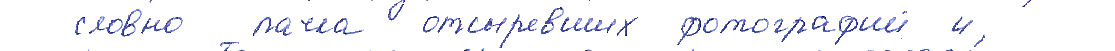

In [102]:
work = Work(WORK_PATHS[randint(0, len(WORK_PATHS)-1)])
page = work.pages[randint(0, len(work.pages)-1)]
line = page.lines[randint(0, len(page.lines)-1)]
line.image

In [103]:
figure(figsize=(50, 50))

trimmed_line, trims = trim(line.image, return_trims=True)

kernel = np.ones(20) / 20
projected_down = np.sum(binarize(trimmed_line), axis=0)
data_convolved_10 = np.convolve(projected_down, kernel, mode='same')
data_convolved_10 = np.convolve(data_convolved_10, kernel, mode='same')
print(np.average(data_convolved_10))
# plt.axhline(np.average(data_convolved_10), color='red')
# plt.plot(data_convolved_10)

2.1872905348526848


<Figure size 3600x3600 with 0 Axes>

In [104]:
from operator import itemgetter
def groupc(sequence):
    ranges = []
    for k,g in itertools.groupby(enumerate(sorted(sequence)),lambda x:x[0]-x[1]):
        group = (map(itemgetter(1),g))
        group = list(map(int,group))
        ranges.append(group)
    return ranges

def find_axis(line: np.array, q: int)-> int:
    """
    A line is projected on the y-axis (i.e. projected left), thus a distribution of pixels along y-axis is built.
    A `q`-percentile of this distribution is taken, indicating the horizontal lines where most of meaningful pixels
        are concentrated. It is possible that at the border of the distribution plot will surpass the percentile.
        To get rid of these pieces, all x's where y > percentile are split into continuous sequences. Then the 
        largest sequence is selected.
    """
    projected_left = np.sum(line, axis=1)
    max_idx = len(projected_left)-1
    percentile = np.percentile(projected_left, q).astype(np.int16)
    where_concentrated = np.where(projected_left > percentile)[0]
    sequences = groupc(where_concentrated)
    longest_sequence = max(sequences, key=len)
    
    if 0 in longest_sequence or max_idx in longest_sequence:
        h,w = line.shape
        minn, med, maxx = int(h * 0.4), int(h * 0.5), int(h * 0.6)
    else:
        minn, med, maxx = min(longest_sequence), np.average(longest_sequence).astype(np.int16), max(longest_sequence)
    return minn, med, maxx

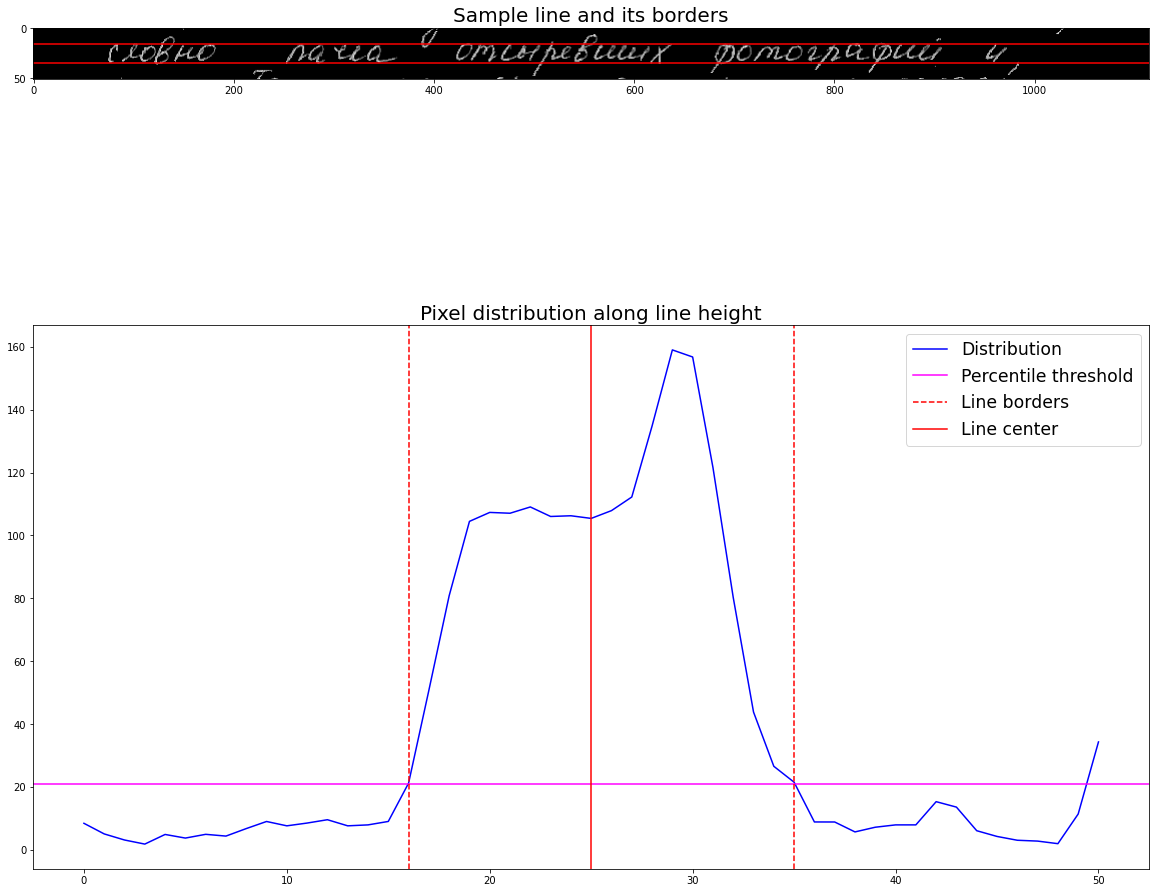

In [105]:
"""LOGIC BEHIND find_axis"""
figure(figsize=(20, 20))
plt.subplots_adjust(hspace=0)
# copy-paste
projected_left = np.sum(line.bin_img, axis=1)
percentile = np.percentile(projected_left, LINE_PROJECTION_PERCENTILE).astype(np.int16)
where_concentrated = np.where(projected_left > percentile)[0]
sequences = groupc(where_concentrated)
longest_sequence = max(sequences, key=len)

ax = plt.subplot(2, 1, 1)
ax.set_title('Sample line and its borders', {"fontsize": 20})
plt.imshow(line.bin_img, cmap='gray')
plt.axhline(y=min(longest_sequence),color='red')
plt.axhline(y=max(longest_sequence), color='red')

ax = plt.subplot(2, 1, 2)
ax.set_title("Pixel distribution along line height", {"fontsize": 20})
plt.plot(projected_left, color='blue')
plt.axhline(y=percentile,color='magenta')
plt.axvline(x=min(longest_sequence),color='red', linestyle='dashed')
plt.axvline(x=np.average(longest_sequence).astype(np.int16), color='red')
plt.axvline(x=max(longest_sequence),color='red', linestyle='dashed')
plt.legend(["Distribution", "Percentile threshold", "Line borders", "Line center"], fontsize='xx-large')


Ошибочная сегментация - это кринж.

Мы хотим принимать в расчёт только промежутки между словами, но не промежутки внутри слова. Для этого было опробовано два эвристических подхода, основанных на ширине пустых пространств,  определённых в изображениях текстовых строк. Во всём документе лишь часть пустых промежутков действительно соответствуют пробелам между словами. Мы отталкиваемся от предположения, что такие пробелы должны быть наибольшими по ширине, т.к. независимо от специфики почерка автор рукописного текста не ставить между буквами промежутки достаточно крупные, чтобы их нельзя было отличить от промежутков между словами. \
Таким образом, нужно определить некоторое значение, соответствующее минимальному размеру пробела между словами. Это значение надлежит определять гранулярно каждой работе, чтобы каждый раз оно определялось применительно к конкретному авторскому почерку. Лишь промежутки, ширина которых больше или равна этому значению, можно считать действительными и рассматривать как валидные границы сегментации.

Разница между эвристическими подходами лишь в том, каким образом можно определить пограничное значение ширины "правильного" пробела.
- Первый: используя значения ширины всех потенциальных промежутков, взять персентильное значение. Недостаток этого подхода в том, что число пробелов в документе может варьироваться в зависимости от специфики авторского почерка - если человек пишет печатными буквами, то потенциальных промежутков небольшого размера образуется больше, чем в работе, написанной слитным почерком (буквы с лигатурами). В таком случае, отсекая по персентильному значению, мы всегда будем отсекать (и одобрять) разное количество промежутков, тогда как в оригинальном тексте есть постоянное число пробелов.
- Второй:  Принимая во внимание недостаток первого подхода, можно взять N наибольших пробелов, где N соответствует числу пробелов в оригинальном тексте. В диктанте 273 пробела, включая те, что обрамляют знаки препинания. Мы принимаем их в расчёт, поскольку избыточная сегментация кажется меньшей проблемой, чем недостаточная сегментация с точки зрения распознавания текста на изображении.

In [106]:
def get_notches_groups(line: Line):
    minn, med, maxx = find_axis(line.bin_img, LINE_PROJECTION_PERCENTILE)
#     # середина линии не в середине строки (примерно). Скорее всего это пустая линия. Скипаем
#     if (int(line.image.height * 0.4) <= med <= int(line.image.height * 0.6)) is None:
#         return None

    trim_result = trim_bin(line.bin_img[minn:maxx], return_trims=True)
    # Это пустая линия. Скипаем
    if trim_result is None:
        return None
    _, trims = trim_result
    trimmed_line_image = line.image.crop((trims['l'], 0, trims['r'], line.image.height))
    
    middle_part = line.bin_img[minn:maxx, trims['l']:trims['r']]
    middle_part_notches = take_notches(middle_part)
    grouped = groupc(middle_part_notches)
    grouped = [g for g in grouped if trims['r'] not in g]

    return line, trimmed_line_image, grouped

In [107]:
def collect_lines_info(work: Work):
    lines, images, groups = [], [], []
    notches_groups_lengths = []
    for each in [line for page in work.pages for line in page.lines]:
        result = get_notches_groups(each)
        if result is None:
            continue
        
        line, image, grouped_consecutive_notches = result
        lines.append(line)
        images.append(image)
        groups.append(grouped_consecutive_notches)
        
        sequenses_lengths = [len(group) for group in grouped_consecutive_notches]
        notches_groups_lengths.extend(sequenses_lengths)
    return lines, images, groups

In [108]:
def segment_line_into_words(line_image: Line, continuous_notches: 'list[int]',  empty_space_min_len = 7):
    # скорее всего это изображение одного слова, т.к. не удалось поставить ни одной насечки.
    # вернём обрезанное изображение
    if len(continuous_notches) == 0:
        return [line_image]
#     empty_space_min_len = np.average([sum(map(len,continuous_notches)) / len(continuous_notches), MIN_EMPTY_SPACE_LEN])
#     filter out small spaces
    continuous_notches = list(filter(lambda x: len(x) > empty_space_min_len, continuous_notches))

    flattened_notches = []
    for list_ in continuous_notches:
        flattened_notches.extend(list_)
    condensed_notches = [0] + condense(flattened_notches) + [line_image.width]

    words = []
    pairs = [(condensed_notches[i], condensed_notches[i+1]) for i in range(len(condensed_notches) - 1)]
    for l, r in pairs:
        words.append(line_image.crop((l, 0, r, line_image.height)))
    return words

In [109]:
def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

Взглянем на распределение размеров пробелов для двух типов почерков. Как видно, при отсутствии лигатурных связок определяется гораздо больше промежутков, причём они имеют небольшой размер. Количество промежутков, размер которых больше медианного значения, в два раза больше для почерка без лигатур по сравнению с классическим рукописным кириллическим почерком.


507 spaces passed threshold



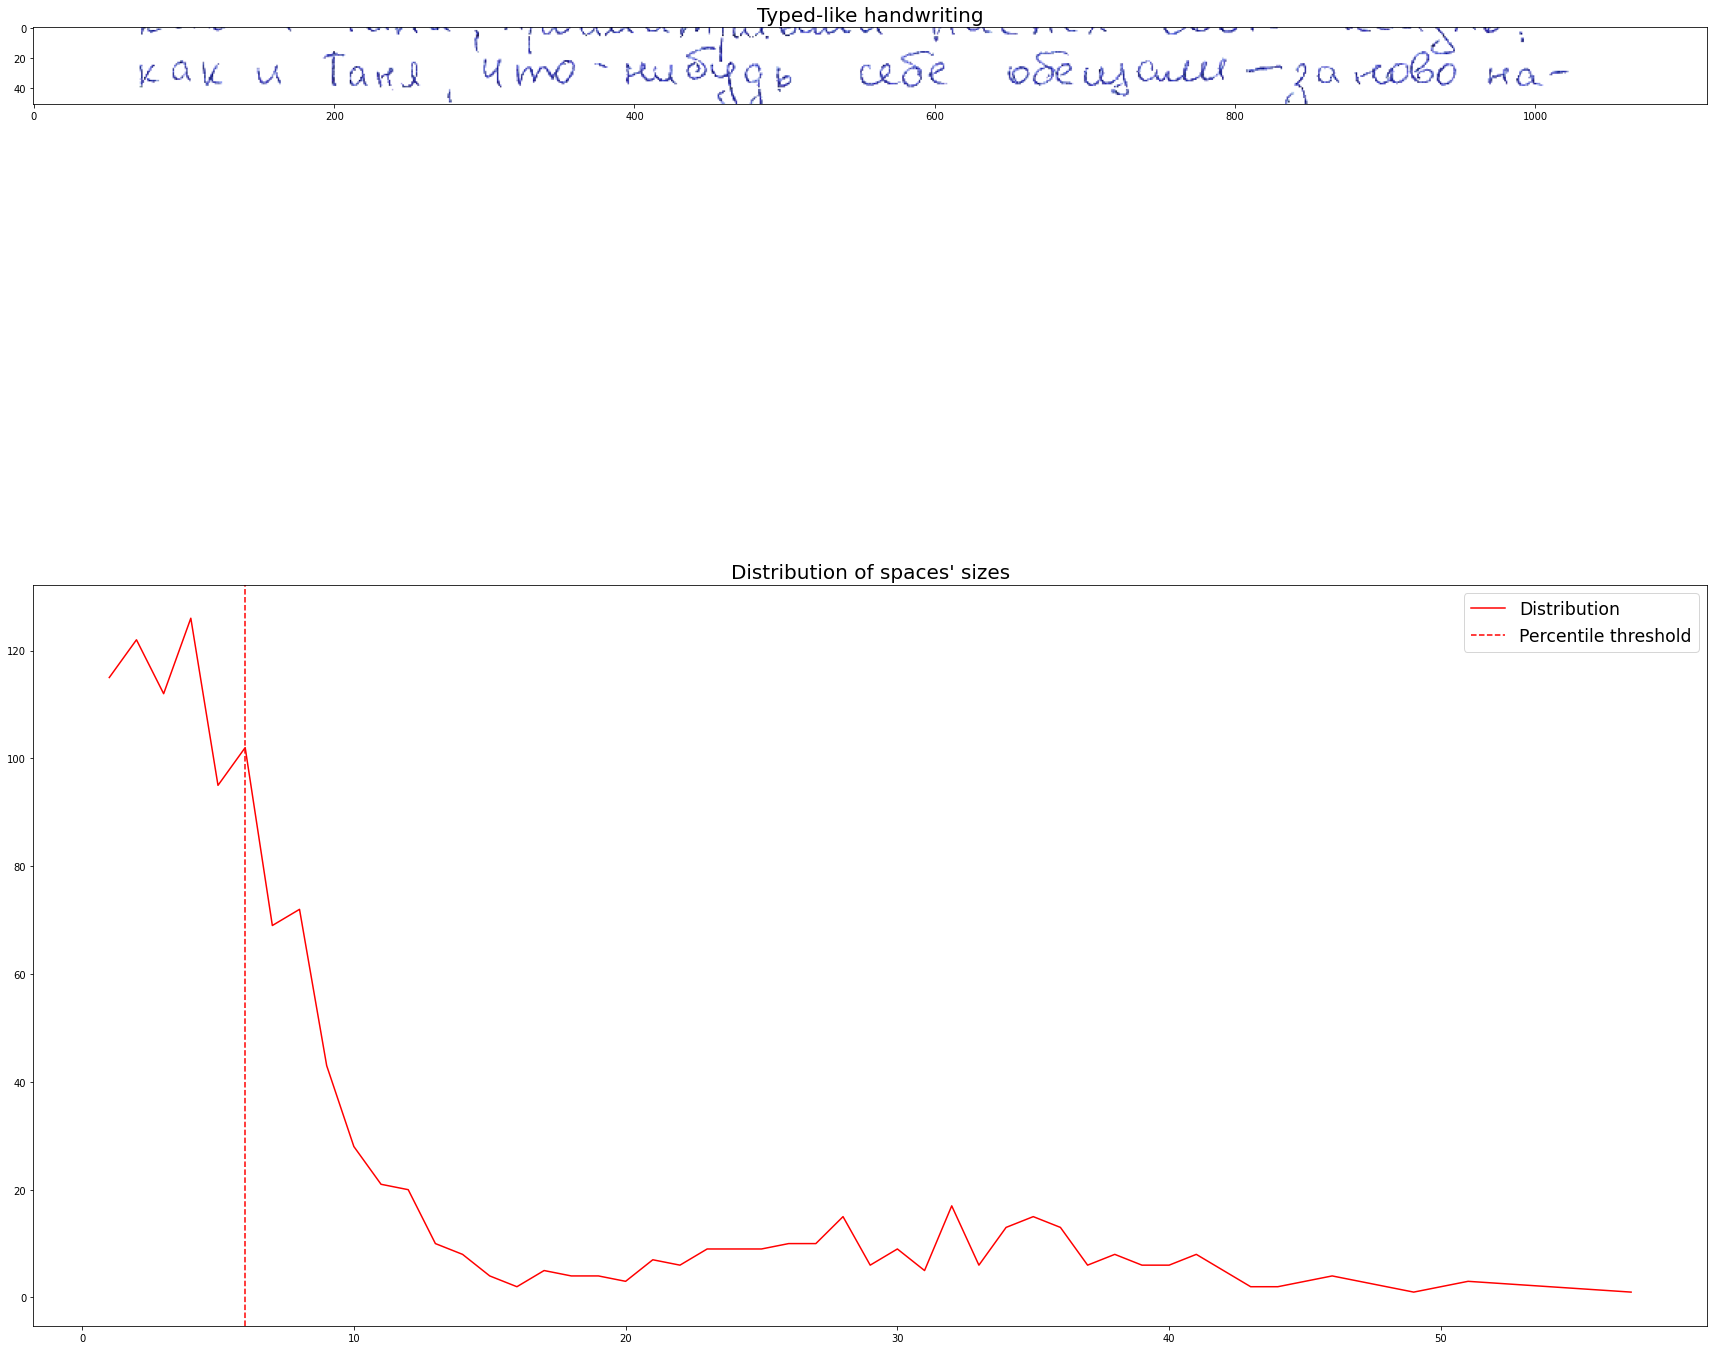

In [110]:
# Пример почти печатного почерка
figure(figsize=(30,30))
work_sparse = Work('../chopped/18956/18956_26')
lines, images, groups = collect_lines_info(work_sparse)

notches_groups_lengths = np.array([len(seq) for group in groups for seq in group])
notches_groups_lengths = notches_groups_lengths[notches_groups_lengths <= 60]
sparse_counter_items = list(sorted(Counter(notches_groups_lengths).items(), key=lambda kv: kv[0]))

ax = plt.subplot(2, 1, 1)
ax.set_title('Typed-like handwriting', {"fontsize": 20})
plt.imshow(work_sparse.pages[0].lines[5].image)

ax = plt.subplot(2, 1, 2)
ax.set_title("Distribution of spaces' sizes", {"fontsize": 20})
x, y = tuple(zip(*sparse_counter_items))
plt.plot(x, y, color="red")
perc = np.percentile(notches_groups_lengths, 50)
plt.axvline(x=perc,color='red', linestyle='dashed')
plt.legend(["Distribution", "Percentile threshold"], fontsize='xx-large')

print(f"""
{len(notches_groups_lengths[notches_groups_lengths > perc])} spaces passed threshold
""")


242 spaces passed threshold



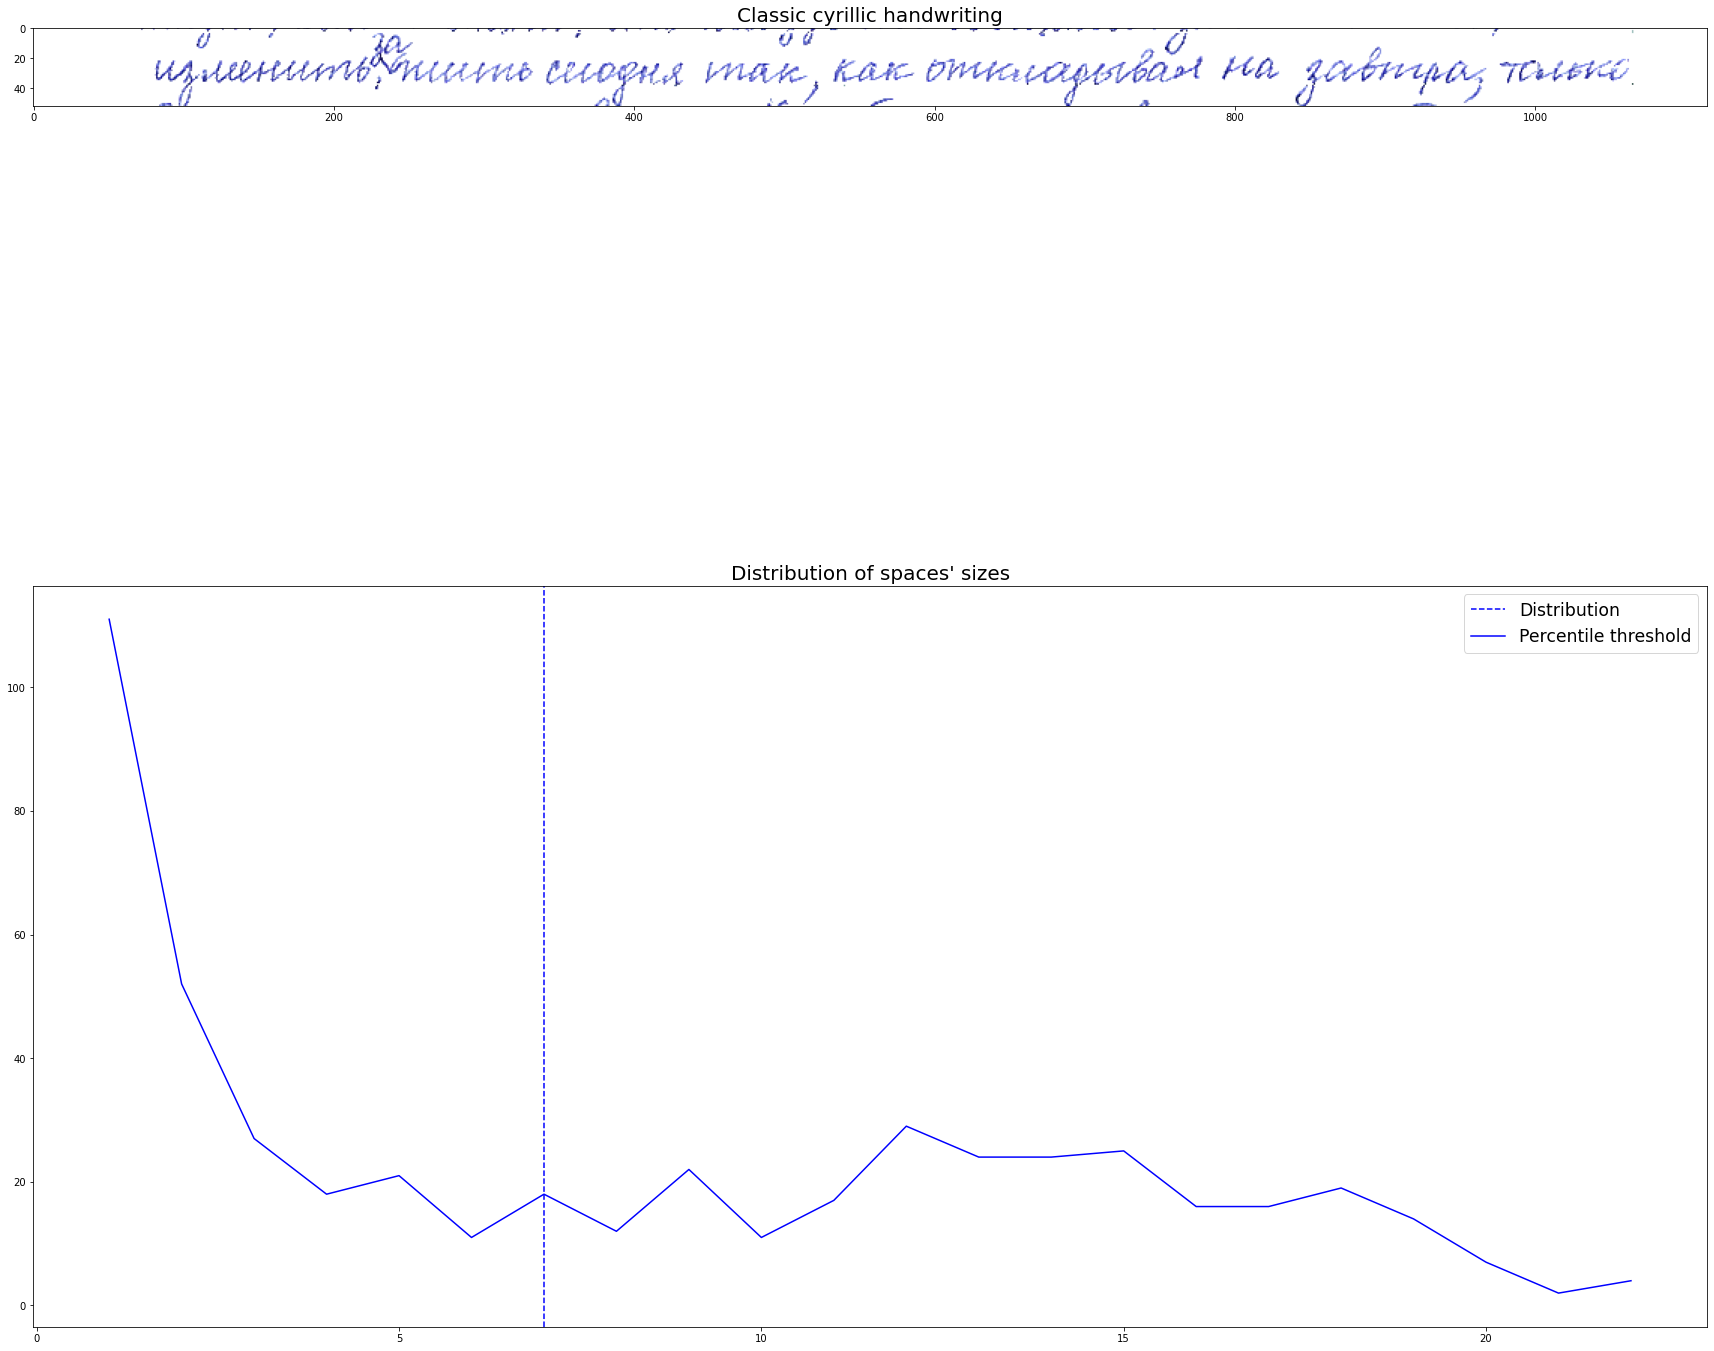

In [111]:
# Пример cлитного почерка
figure(figsize=(30,30))
work_dense = Work('../chopped/18956/18956_16')
lines, images, groups = collect_lines_info(work_dense)

notches_groups_lengths = np.array([len(seq) for group in groups for seq in group])
notches_groups_lengths = notches_groups_lengths[notches_groups_lengths <= 60]
dense_counter_items = list(sorted(Counter(notches_groups_lengths).items(), key=lambda kv: kv[0]))

ax = plt.subplot(2, 1, 1)
ax.set_title('Classic cyrillic handwriting', {"fontsize": 20})
plt.imshow(work_dense.pages[0].lines[5].image)

ax = plt.subplot(2, 1, 2)
x, y = tuple(zip(*dense_counter_items))
perc = np.percentile(notches_groups_lengths, 50)
plt.axvline(x=perc,color='blue', linestyle='dashed')
ax.set_title("Distribution of spaces' sizes", {"fontsize": 20})
plt.plot(x, y, color="blue")
plt.legend(["Distribution", "Percentile threshold"], fontsize='xx-large')

print(f"""
{len(notches_groups_lengths[notches_groups_lengths > perc])} spaces passed threshold
""")

**Practical appliance**

In [112]:
WORK_PATHS[randint(0, len(WORK_PATHS)-1)]

'../chopped/18525/18525_49'

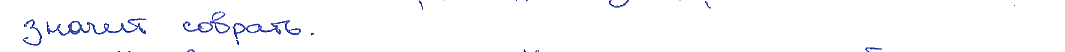

In [113]:
work = Work(WORK_PATHS[randint(0, len(WORK_PATHS)-1)])
page = work.pages[randint(0, len(work.pages)-1)]
line = page.lines[randint(0, len(page.lines)-1)]
line.image

7
19 34


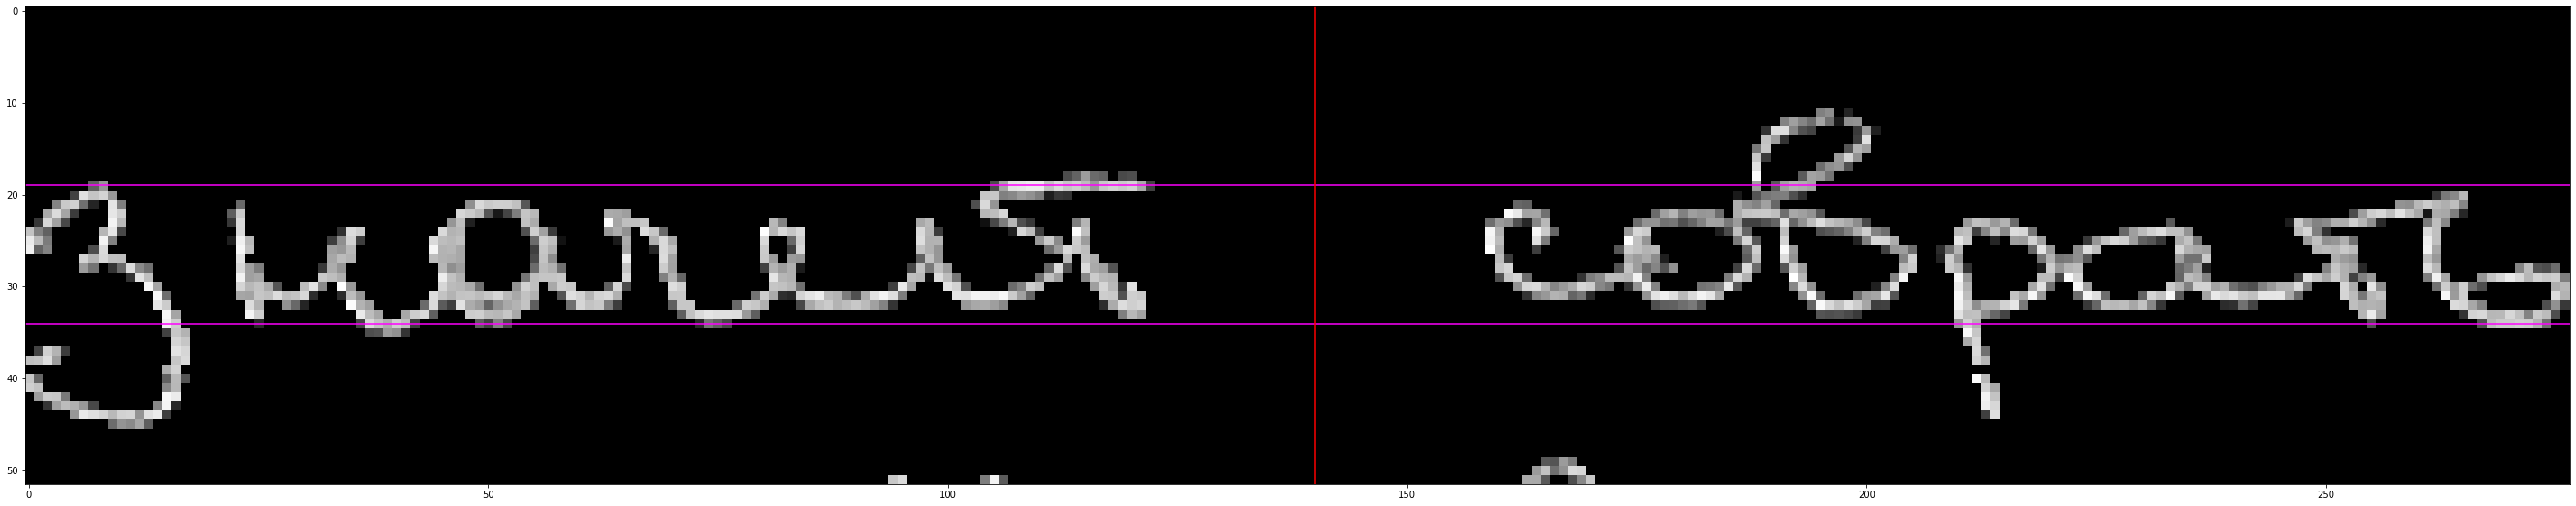

In [114]:
"""EXTRACT WORDS DEMO"""
h, w = line.bin_img.shape
figure(figsize=(50, 50))

notches_groups_lengths = list()
for each in [line for page in work.pages for line in page.lines]:
    groups = get_notches_groups(each)
    if groups is None:
        continue
    _, _, grouped_consecutive_notches = groups
    sequenses_lengths = [len(group) for group in grouped_consecutive_notches]
    notches_groups_lengths.extend(sequenses_lengths)

# take the Nth largest group, given N spaces in the whole text
notches_groups_lengths.sort(reverse=True)
empty_space_min_len = notches_groups_lengths[273]
print(empty_space_min_len)

minn, med, maxx = find_axis(line.bin_img, LINE_PROJECTION_PERCENTILE)
print(minn, maxx)

_, trims = trim_bin(line.bin_img[minn:maxx], return_trims=True)
middle_part = line.bin_img[minn:maxx, trims['l']:trims['r']]
middle_part_notches = take_notches(middle_part)

merged_notches = set()
# for notch in lower_part_notches | middle_part_notches | upper_part_notches:
#     in_up = notch in upper_part_notches
#     in_mid = notch in middle_part_notches
#     in_low =  notch in lower_part_notches
#     if in_mid:
#         merged_notches.add(notch)
for notch in middle_part_notches:
    merged_notches.add(notch)
    
continuous_notches = groupc(merged_notches)
# empty_space_min_len = np.average([sum(map(len,continuous_notches)) / len(continuous_notches), 7])
# filter out small spaces
continuous_notches = list(filter(lambda x: len(x) > empty_space_min_len, continuous_notches))

flattened_notches = []
for list_ in continuous_notches:
    flattened_notches.extend(list_)
condensed_notches = condense(flattened_notches)

shown = line.bin_img[:,trims['l']:trims['r']]
plt.axhline(y=minn,color='magenta')
plt.axhline(y=maxx,color='magenta')

plt.imshow(shown, 'gray')
for x in condensed_notches:
    plt.axvline(x=x,color='red')

In [93]:
TOTAL_SPACES = 273
def extract_words(work):
    lines, images, groups = collect_lines_info(work)
    # empty_space_min_len = np.percentile(notches_groups_lengths, 75)
    notches_groups_lengths = [len(seq) for group in groups for seq in group]
    notches_groups_lengths.sort(reverse=True)
    notches_groups_lengths = reject_outliers(np.array(notches_groups_lengths))
    try:
        empty_space_min_len = notches_groups_lengths[:TOTAL_SPACES][-1]
    except:
        print(notches_groups_lengths[:TOTAL_SPACES])
        print(len(notches_groups_lengths))
        print(work)
        return
    
    for line, image, group in zip(lines, images, groups):
        line_num = os.path.basename(line.path).replace(".png", "")
        page_path = line.path.split('/')[-2]
        destination = f"../formatted_data/words/{work.work_id}/{page_path}/{line_num}"
        os.makedirs(destination, exist_ok=True)
        words = segment_line_into_words(image, group, empty_space_min_len)
        for i, word in enumerate(words):
            stripe = take_central_stripe(word)
            trimmed = trim(stripe, return_trims=True)
            if trimmed is None:
                continue
            _, trims = trimmed
            if trims['r'] - trims['l'] > 10:
                word.crop((trims['l'],0,trims['r'],word.height)). \
                    convert("RGB"). \
                    save(f"{destination}/{i}.jpg")
                
for work in tqdm((Work(path) for path in WORK_PATHS), total=514):
    extract_words(work)

100%|█████████████████████████████████████████| 514/514 [04:18<00:00,  1.99it/s]


#### Alignment baseline

In [ ]:
len(dictation_text)

In [94]:
def alignment_baseline(work: Work):
    text_generator = enumerate(dictation_text)
    source = f"/home/arcamu/Documents/Uni/Disser/formatted_data/words/{work.work_id}"
    images = glob(f"{source}/**/*.jpg", recursive=True)
    
    destination = f"../formatted_data/word_alignment/{work.work_id}/"
    os.makedirs(destination, exist_ok=True)
    i = 0
    images.sort(key=lambda path: int(path.split('/')[-1].replace(".jpg", "")))
    images.sort(key=lambda path: int(path.split('/')[-2]))
    images.sort(key=lambda path: int(path.split('/')[-3][-1]))
    for image_path in images:
        next_word = next(text_generator, None)
        if next_word is None:
            return
        image = im.open(image_path)
        i, word = next_word
        image.convert("RGB").save(f"{destination}/{i}_{word}.jpg")

for work in tqdm((Work(path) for path in WORK_PATHS), total=514):
    alignment_baseline(work)

100%|█████████████████████████████████████████| 514/514 [01:20<00:00,  6.38it/s]


**Alignment advanced**

In [138]:
""" 
merge_image takes three parameters first two parameters specify 
the two images to be merged and third parameter i.e. vertically
is a boolean type which if True merges images vertically
and finally saves and returns the file_name
"""
def concat_images(img1, img2, vertically=False):
    images = [img1, img2]
    widths, heights = zip(*(i.size for i in images))
    if vertically:
        max_width = max(widths)
        total_height = sum(heights)
        new_im = im.new('RGB', (max_width, total_height))

        y_offset = 0
        for each in images:
            new_im.paste(each, (0, y_offset))
            y_offset += each.size[1]
    else:
        total_width = sum(widths)
        max_height = max(heights)
        new_im = im.new('RGB', (total_width, max_height))

        x_offset = 0
        for each in images:
            new_im.paste(each, (x_offset, 0))
            x_offset += each.size[0]
    return new_im


In [282]:
TOTAL_LETTERS = 1485
def alignment_advanced(work: Work):
    text_generator = enumerate(dictation_text)
    source = f"../formatted_data/words/{work.work_id}"
    image_paths = glob(f"{source}/**/*.jpg", recursive=True)
    destination = f"../formatted_data/word_alignment_advanced/{work.work_id}/"
    os.makedirs(destination, exist_ok=True)
    i = 0
    image_paths.sort(key=lambda path: int(path.split('/')[-1].replace(".jpg", "")))
    image_paths.sort(key=lambda path: int(path.split('/')[-2]))
    image_paths.sort(key=lambda path: int(path.split('/')[-3][-1]))
    
    images = []
    total_width = 0
    for image_path in image_paths:
        image = im.open(image_path)
        images.append(image)
        total_width += image.width
        
    average_letter_width = total_width // TOTAL_LETTERS
    
    image_idx = 0
    word_idx = 0
    result = []
    while word_idx < len(dictation_text) and image_idx < len(images):
        word = dictation_text[word_idx]
        word_len = len(word)
        image = images[image_idx]
        expected_width = word_len * average_letter_width
        
        accumulating = True
        while accumulating and image_idx < len(images)-1:
            next_image = images[image_idx + 1]
            if next_image.width + image.width <= expected_width * 0.8:
                image_idx += 1
                image = concat_images(image, next_image)
            else:
                accumulating = False
        
        image_idx += 1
        word_idx += 1
        result.append((word, image))
    return result



for work in tqdm((Work(path) for path in WORK_PATHS[7:8]), total=514):
    x = alignment_advanced(work)

  0%|                                           | 1/514 [00:00<01:40,  5.08it/s]


In [283]:
num_gen = (i for i in range(273))

шелестели


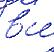

In [296]:
idx = next(num_gen)
print(x[idx][0])
x[idx][1]

### Trying to remove little stuff from image borders

In [2]:
""" HOUGH lines don't work """

# open_cv_image = np.array(words[1])[:, :, ::-1]
# open_cv_image = cv2.Canny(open_cv_image, 50, 200, None, 3)

# cdst = cv2.cvtColor(open_cv_image, cv2.COLOR_GRAY2BGR)
# cdstP = np.copy(cdst)

# lines = cv2.HoughLinesP(open_cv_image, 1, np.pi / 180, 50, None, 50, 10)
# print(lines)
# if lines is not None:
#     for i in range(0, len(lines)):
#         l = lines[i][0]
#         cv2.line(cdstP, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv2.LINE_AA)

# plt.imshow(cdstP)

" HOUGH lines don't work "

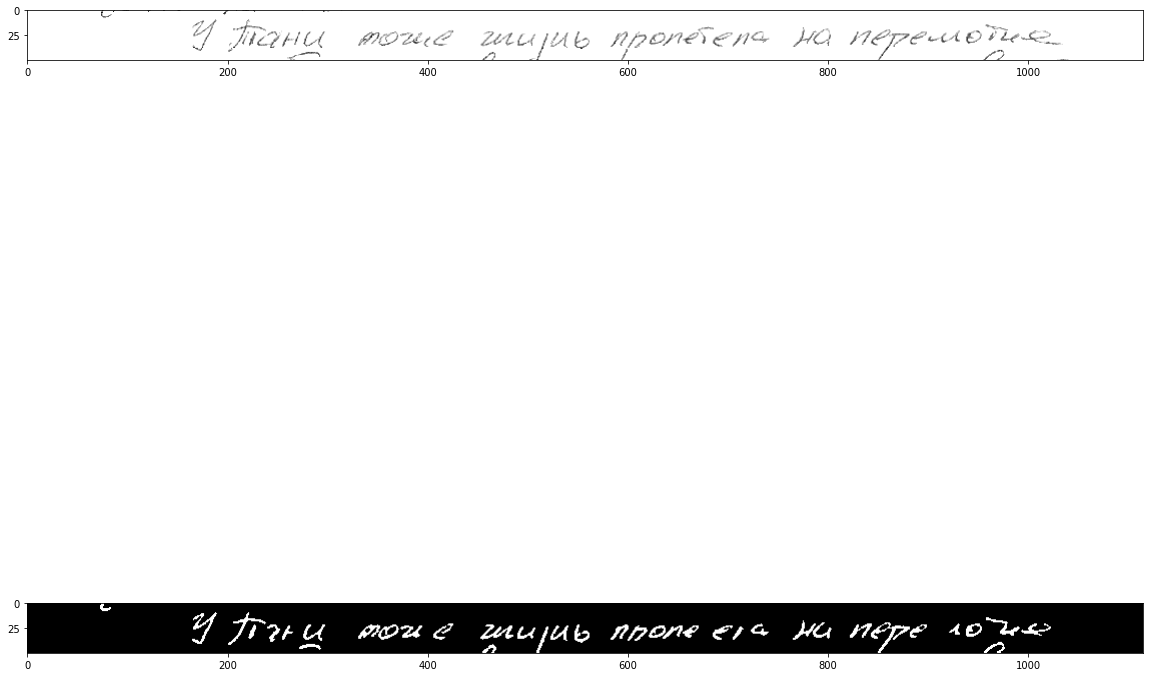

In [117]:
""" DELETE BY CONTOUR. DOESN'T WORK CUZ LETTERS CAN BE TOO SMALL"""
figure(figsize=(20, 20))
import cv2

# Load image, convert to grayscale, Gaussian blur, Otsu's threshold
image = np.array(line.image)[:, :, ::-1]
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (3,3), 1)
thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# Filter using contour area and remove small noise
cnts = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    area = cv2.contourArea(c)
    if area < 30:
        cv2.drawContours(thresh, [c], -1, (0,0,0), -1)

# Morph close and invert image
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
close = 255 - cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)
plt.subplot(2, 1, 1)
plt.imshow(gray, cmap='gray')
plt.subplot(2, 1, 2)
plt.imshow(thresh, cmap='gray')

In [4]:
""" FLOOD FILL ELEMENTS THAT ARE ON BORDER """

# figure(figsize=(20, 20))

# floodFilled = gray.copy()
# _, floodFilled = cv2.threshold(floodFilled, thresh=180, maxval=255, type=cv2.THRESH_BINARY)
# for id in list(id for id, x in enumerate(floodFilled[1]) if x == 0):
#     cv2.floodFill(floodFilled, None,(id,1),255)
# plt.imshow(floodFilled, cmap="gray")

' FLOOD FILL ELEMENTS THAT ARE ON BORDER '